# Metropolis Monte Carlo for 2D Ising Model

$\textbf{2D Ising Model:}$Ising Model is one of the simple yet effective model which consists of a lattice with fixed number of sites. Each Lattice site has a spin with two degree of freedom (Si = ±1). Spins can either align themselves in upward direction(Si = +1) or in the downward(Si = +1) direction. The shape of the lattice here is s square . Thus, a two dimensional Ising Model with a size of L will consist of $L^2$ spins.

$\textbf{NOTE:}$ Use $\textit{Shift+Enter}$ to run the codes written in the cells.

## Need for Metropolis Algorithm
$\textit{Probabaility}$ of each microstate is given by:
$\begin{align}\tag{2.1}
P_c = \dfrac{e^{-\beta \hat{H}_i}}{\sum_ce^{-\beta \hat{H}_i}}
\end{align}$

To get the precise value of magnetization, we must calculate the magnetization for as many microstates/configurations as possible and then take the mean. Generating each and every microstate is a hopeless effort (For a small lattice size of L=10, number of possible microstates are $2^{100}$ ).
$\begin{align}\tag{1.1}
\langle M\rangle  = \dfrac{\sum_{c=1}^{2^{100}}m_c\times P_c}{2^{100}}
\end{align}$

But as in (1.1) the probability of every microstate is different. Without generating every single configuration, one can sample only those configurations which contribute most to the average (3.2). This is known as importance sampling. Here, the role of Metropolis Monte Carlo comes in. This importance sampling based algorithm reduces the computational time by a significant amount.

### Steps for 2D Ising simulation:

1.Create a configuration with random alignment of spins.

2.Randomly select a spin and flip it, to generate a trial configuration.

3.Compute the energy difference ($\Delta E = E_B-E_A$).

4.If $\Delta E<0$, accept the trial configuration with acceptance probability 1.

5.If $\Delta E>0$, accept the trial configuration with acceptance probability $e^{-\Delta E}$.

6.Perform sampling for large number of cycles.

## Code for equilibration
This function is called by the main file whenever necessary.

In [135]:
addprocs(4)

4-element Array{Int64,1}:
 14
 15
 16
 17

In [150]:
@everywhere using Distributed
@everywhere using Statistics

In [151]:
@everywhere function Equilibration(n_grid,T,J,L)

#creating random arrangement
grid=randn(n_grid,n_grid)
for i in 1:n_grid^2
    if grid[i]>0.5
        grid[i]=1
    else
        grid[i]=-1
    end
end

numIters = (2^9)*length(grid)

#pick a random spin
for iter in 1:numIters
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    
    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors)
    
    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col]
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col]
        end
    end
end
return grid
end

## Code for Calculating average properties (Production Run)
This function is called by the main file whenever necessary.

In [152]:
#Production
@everywhere function Production(n_grid,T,J,L,grid)
Mmean=zeros(1,L)
Emean=zeros(1,L)
for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    
    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors)
    
    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col]
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col]
        end
    end
    
    #Calculating Properties
    Mmean[1,iter]=mean(grid)
    
    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
Ms=mean(Mmean);
#Es=mean(Emean)
xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr, Ms, xs
end

## Code for generating equilibrated arrangements by calling Equilibration
This function generates equilibrated arrangement for different temperatures.
It is called by the main code whenever necessary.

In [153]:
T=Array{Float64,(1,5+1)}
Ts=Array{Float64,(1,5+1)}
gridqm=Array{Array{Int8,(1,7+1)},(1,8+1)}
a=zeros(2,5,5)
a[1,:,:]
b=[ 2 3 4 5 6]
c= mean(b)

4.0

In [154]:
@everywhere function ising_over_temp(n_grid,J,L,Tmin,Tinc,Tmax)
len = floor((Tmax-Tmin)/Tinc);
len=convert(Int64,len);
#allocating required memory
gridqm=zeros(len+1,n_grid,n_grid);
Ts=zeros(len+1);
i=1;

# The temperature loop
print("equilibration started!","\n");
print("Number of steps = ",(2^8)*n_grid^2,"\n");
for T in Tmin:Tinc:Tmax
    grid = Equilibration(n_grid, T, J, L);

    #storing equilibrated arrangements with temperature 
    gridqm[i,:,:] = grid;
    Ts[i] = T;
    i=i+1;
end
print("equilibration finished!","\n");
len = length(Ts);
return gridqm, Ts, len
end

In [155]:
@everywhere function Ising(n_grid,L,J,P,Tmin,Tinc,Tmax)
gridqm, Ts, len = ising_over_temp(n_grid,J,L,Tmin,Tinc,Tmax)

Mp=zeros(P,len);
x=zeros(P,len);

for Pr in 1:P
    print("production run = ",Pr,"\n")
    for h in 1:len
        gridpr,Ms,xs = Production(n_grid,Ts[h],J,L,gridqm[h,:,:])
        #print(h,"\n")
        Mp[Pr,h] = Ms;
        x[Pr,h] = xs;
    end
end

Mp_avg=mean(Mp,dims=1);
x_avg=mean(x,dims = 1);
Ts



#using Plots
#plt1 = Plots.scatter(Ts,Mp_avg,color="red",legend=false,xaxis="Temp",yaxis="<M>/spin");
#plt2 = Plots.scatter(Ts,x_avg,color="green", reuse= false,legend=false,xaxis="Temp",yaxis="<x>/spin");
#display(plt1)
#display(plt2)

    #using Gadfly
    #plt1=plot(x=Ts,y=Mp_avg,Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
    #plt2=plot(x=Ts,y=x_avg,Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
    #display(plt1)
    #display(plt2)

    print("FINISHED!")
    return Mp_avg, x_avg, Ts
end

## Main Code with input parameters
$\textbf{NOTE:}$Run all the codes in above cells before running this main code as it uses functions which are defined above.

This is the main code that calculates magnetisation and susceptibility.

Change the input parameters within next cell and press $\textit{Shift+Enter}$ to run the simulation.

$\textbf{Parameters ==>>}$ Ising(Lattice Size, MC steps, J, No. of Production Run, Tmin, Tinc, Tmax)

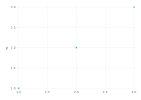

In [156]:
plt_1=plot(y=[1,2,3])
#display(plt_1)

equilibration started!
Number of steps = 640000
equilibration finished!
production run = 1
production run = 2
FINISHED! 21.568975 seconds (60.98 M allocations: 6.380 GiB, 6.35% gc time)


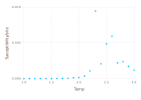

In [157]:
Mp_avg, x_avg, Ts = @time Ising(50,1000000,1,2,1,0.1,3)
using Gadfly
plt1=plot(x=Ts,y=Mp_avg,Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=Ts,y=x_avg,Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
#display(plt1)
#display(plt2)

## Now using Parallel Programing

addprocs will allow this Jupyter notebook to use all the workers (CPUs) in this machine. I have 4 cores including hyperthreading. So,

In [158]:
addprocs(4)

4-element Array{Int64,1}:
 22
 23
 24
 25

$\textit{@spawn}$ is the syntax for distributing the jobs to the cores in a for loop. At the end, we divide by the number of cores to get the average estimate of properties among the cores.
Total MC steps will be diving within 4 cores.

In [159]:
@everywhere function parallel_Ising(n_grid,L,J,P,Tmin,Tinc,Tmax,ncores::Int=4)

    #Compute properties in parallel, over ncores cores, with a Monte Carlo simulation 
    #Dividing MC steps over all available cores in parallel
    a=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    b=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    c=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    d=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    Mp1,x1,T1 = fetch(a)
    Mp2,x2,T2 = fetch(b)
    Mp3,x3,T3 = fetch(c)
    Mp4,x4,T4 = fetch(d)
    
     Mp_avg=(Mp1+Mp2+Mp3+Mp4)/ncores
    x_avg=(x1+x2+x3+x4)/ncores
    Ts=(T1+T2+T3+T4)/ncores
    return Mp_avg, x_avg, Ts  # average value
end

This is the main code that calculates magnetisation and susceptibility by using all the CPU.

Change the input parameters within next cell and press $\textit{Shift+Enter}$ to run the simulation.

$\textbf{Parameters ==>>}$ parallel_Ising(Lattice Size, MC steps, J, No. of Production Run, Tmin, Tinc, Tmax)

In [160]:
@time parallel_Ising(50,1000000,1,2,1,0.1,3)
using Gadfly
plt1=plot(x=Ts,y=Mp_avg,Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=Ts,y=x_avg,Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
display(plt1)
display(plt2)

      From worker 21:	equilibration started!
      From worker 20:	equilibration started!
      From worker 21:	Number of steps = 640000
      From worker 18:	equilibration started!
      From worker 20:	Number of steps = 640000
      From worker 19:	equilibration started!
      From worker 19:	Number of steps = 640000
      From worker 18:	Number of steps = 640000
      From worker 21:	equilibration finished!
      From worker 21:	production run = 1
      From worker 18:	equilibration finished!
      From worker 18:	production run = 1
      From worker 20:	equilibration finished!
      From worker 20:	production run = 1
      From worker 19:	equilibration finished!
      From worker 19:	production run = 1
      From worker 18:	production run = 2
      From worker 19:	production run = 2
      From worker 20:	production run = 2
      From worker 21:	production run = 2
 12.168169 seconds (1.48 M allocations: 71.549 MiB, 0.17% gc time)


In [161]:
@everywhere function m_hist_mc(n_grid,T,J,L,grid)
    m_hist = -(n_grid^2):2:(n_grid^2) ; m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; e_hist = collect(e_hist)
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ; e_hist = [ e_hist zeros(length(e_hist),1) ]

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; Enew = Eold + dE;

    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col] ; Eold = Enew ; Mnew = sum(grid) ; Mold = Mnew ;
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col] ; Eold = Enew ;
            Mnew = sum(grid) ; Mold = Mnew ;
        end
    end

    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist
end


In [162]:
# grid = Equilibration(n_grid, T, J, L);
grid = Equilibration(8,2.5,1,100000)
# function m_hist_mc(n_grid,T,J,L,grid)


8×8 Array{Float64,2}:
 -1.0  -1.0   1.0   1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0   1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0   1.0
 -1.0   1.0   1.0   1.0   1.0  -1.0  -1.0  -1.0
  1.0   1.0   1.0   1.0   1.0   1.0  -1.0  -1.0

In [163]:
@time gridpr, m_hist, e_hist = m_hist_mc(8,2.5,1,10000000,grid)

  4.703834 seconds (78.48 M allocations: 1.783 GiB, 3.94% gc time)


([-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-64.0 43714.0; -62.0 115214.0; … ; 62.0 119600.0; 64.0 45246.0], [-128.0 88960.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0])

In [164]:
m_hist 

e_hist

65×2 Array{Float64,2}:
 -128.0   88960.0
 -124.0       0.0
 -120.0  234814.0
 -116.0   92460.0
 -112.0  345403.0
 -108.0  266746.0
 -104.0  437593.0
 -100.0  436385.0
  -96.0  529805.0
  -92.0  551945.0
  -88.0  607592.0
  -84.0  631581.0
  -80.0  659281.0
    ⋮            
   84.0       0.0
   88.0       0.0
   92.0       0.0
   96.0       0.0
  100.0       0.0
  104.0       0.0
  108.0       0.0
  112.0       0.0
  116.0       0.0
  120.0       0.0
  124.0       0.0
  128.0       0.0

In [165]:
sum(e_hist[:,2])
#sum(e_hist[:,2])

1.0e7

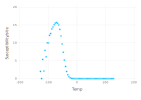

In [167]:
using Gadfly
plt1=plot(x=m_hist[:,1],y=m_hist[:,2]./m_hist[1,2],Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=e_hist[:,1],y=e_hist[:,2]./m_hist[1,2],Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
#display(plt1)
#display(plt2)

In [168]:
@everywhere function Equilibration(n_grid,T,J,L)

#creating random arrangement
grid=randn(n_grid,n_grid)
for i in 1:n_grid^2
    if grid[i]>0.5
        grid[i]=1
    else
        grid[i]=-1
    end
end

numIters = (2^9)*length(grid)

#pick a random spin
for iter in 1:numIters
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    
    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors)
    
    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col]
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col]
        end
    end
end
return grid
end

In [169]:
@everywhere function m_tmmc(n_grid,T,J,L,grid)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist)
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ;
        else
            Mnew = Mold - 2 ;
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
            m_tm[m_old_index,4] += prob ;
        end
        
        

    #Spin flip condition
   # if dE <= 0
      #  grid[row,col] = -grid[row,col] ; 
          #  Eold = Enew ; 
           # Mnew = sum(grid) ; 
          #  Mold = Mnew ;
   # else
        
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end
    #end

    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
    


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tm
end


In [170]:
# grid = Equilibration(n_grid, T, J, L);
grid = Equilibration(8,1.5,1,100000)
# function m_hist_mc(n_grid,T,J,L,grid)


8×8 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

In [171]:
@time grid, m_hist, e_hist, m_tm = m_tmmc(8,1.5,1,1e7,grid)

  7.822183 seconds (140.38 M allocations: 2.850 GiB, 3.35% gc time)


([-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-64.0 7.00058e6; -62.0 2.14652e6; … ; 62.0 0.0; 64.0 0.0], [-128.0 7.00058e6; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 7.00058e6 33798.5 0.0; -62.0 2.14652e6 18835.7 33573.0; … ; 62.0 0.0 0.0 0.0; 64.0 0.0 0.0 0.0])

In [172]:
m_hist

65×2 Array{Float64,2}:
 -64.0       7.00058e6
 -62.0       2.14652e6
 -60.0  595051.0      
 -58.0  168756.0      
 -56.0   55708.0      
 -54.0   19333.0      
 -52.0    7991.0      
 -50.0    2964.0      
 -48.0    1682.0      
 -46.0     691.0      
 -44.0     354.0      
 -42.0     192.0      
 -40.0      57.0      
   ⋮                  
  42.0       0.0      
  44.0       0.0      
  46.0       0.0      
  48.0       0.0      
  50.0       0.0      
  52.0       0.0      
  54.0       0.0      
  56.0       0.0      
  58.0       0.0      
  60.0       0.0      
  62.0       0.0      
  64.0       0.0      

In [173]:
e_hist

65×2 Array{Float64,2}:
 -128.0       7.00058e6
 -124.0       0.0      
 -120.0       2.14652e6
 -116.0  290488.0      
 -112.0  375717.0      
 -108.0   99545.0      
 -104.0   56140.0      
 -100.0   19056.0      
  -96.0    8038.0      
  -92.0    2282.0      
  -88.0    1113.0      
  -84.0     391.0      
  -80.0      92.0      
    ⋮                  
   84.0       0.0      
   88.0       0.0      
   92.0       0.0      
   96.0       0.0      
  100.0       0.0      
  104.0       0.0      
  108.0       0.0      
  112.0       0.0      
  116.0       0.0      
  120.0       0.0      
  124.0       0.0      
  128.0       0.0      

In [174]:
m_tm

65×4 Array{Float64,2}:
 -64.0       7.00058e6  33798.5          0.0    
 -62.0       2.14652e6  18835.7      33573.0    
 -60.0  595051.0         7799.11     18693.0    
 -58.0  168756.0         3418.5       7763.0    
 -56.0   55708.0         1420.46      3451.43   
 -54.0   19333.0          627.502     1372.58   
 -52.0    7991.0          291.552      639.514  
 -50.0    2964.0          147.461      283.768  
 -48.0    1682.0           93.4453     159.138  
 -46.0     691.0           36.104       87.3298 
 -44.0     354.0           25.1962      36.3298 
 -42.0     192.0            7.87231     23.635  
 -40.0      57.0            2.90916      6.55587
   ⋮                                            
  42.0       0.0            0.0          0.0    
  44.0       0.0            0.0          0.0    
  46.0       0.0            0.0          0.0    
  48.0       0.0            0.0          0.0    
  50.0       0.0            0.0          0.0    
  52.0       0.0            0.0          0.0  

In [175]:
m_tmn = copy(m_tm);
m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
m_tm_hist = ones(length(m_tmn[:,1]))
m_tm_hist
for iter in 2:length(m_tmn[:,1])
    m_tm_hist[iter] = m_tmn[iter-1,3]./m_tmn[iter,4];
end
m_tm_hist = cumprod(m_tm_hist)

65-element Array{Float64,1}:
   1.0                   
   0.3086786131877322    
   0.08622439836169003   
   0.024566907814283327  
   0.008032404848174737  
   0.002884815049580759  
   0.0011699971122570538 
   0.0004458758339383306 
   0.0002344578853086737 
   0.00010306507288067342
   5.247216924394149e-5  
   3.0339304402216685e-5 
   1.081561309109772e-5  
   ⋮                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     

In [176]:
sum(e_hist[:,2])

1.0e7

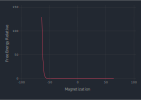

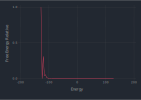

Stacktrace:
 [1] depwarn(::String, ::Symbol) at .\deprecated.jl:70
 [2] color(::String) at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\Colors\src\parse.jl:152
 [3] include_string(::String, ::String) at .\loading.jl:522
 [4] include_string(::Module, ::String, ::String) at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\Compat\src\Compat.jl:71
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\IJulia\src\execute_request.jl:158
 [6] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\Compat\src\Compat.jl:385
 [7] eventloop(::ZMQ.Socket) at C:\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\IJulia\src\eventl

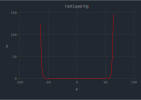

In [210]:
using Gadfly
plt1=plot(x=m_hist[:,1],y=m_hist[:,2]./m_hist[5,2],Geom.line,Guide.xlabel("Magnetization"),Guide.ylabel("Free Energy Relative"))
plt2=plot(x=e_hist[:,1],y=e_hist[:,2]./e_hist[1,2],Geom.line,Guide.xlabel("Energy"),Guide.ylabel("Free Energy Relative"))
display(plt1)
display(plt2)
plt3 = plot(#layer(x=m_hist[:,1],y=m_hist[:,2]./m_hist[5,2],Geom.line,Theme(default_color=color("green"))),
   # layer(x=m_hist[:,1],y=m_tm_hist./m_tm_hist[5],Geom.line,Theme(default_color=color("white"))),
   layer(x=m_hist[:,1],y=m_tm_hist_bm./m_tm_hist_bm[5],Geom.line,Theme(default_color=color("red"))),
    #layer(x=m_hist[:,1],y=m_hist_bm[:,2]./m_hist_bm[5,2],Geom.line,Theme(default_color=color("blue"))),
Guide.title("testLayering"))

In [177]:
m_tm_hist

65-element Array{Float64,1}:
   1.0                   
   0.3086786131877322    
   0.08622439836169003   
   0.024566907814283327  
   0.008032404848174737  
   0.002884815049580759  
   0.0011699971122570538 
   0.0004458758339383306 
   0.0002344578853086737 
   0.00010306507288067342
   5.247216924394149e-5  
   3.0339304402216685e-5 
   1.081561309109772e-5  
   ⋮                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     
 NaN                     

In [178]:
@everywhere function m_tmmc_biased(n_grid,T,J,L,grid,is_biased)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist)
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ;
        else
            Mnew = Mold - 2 ;
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
            m_tm[m_old_index,4] += prob ;
        end
        
        
        #bias calculation
        bias = 1 ;
        if is_biased == true
        if iter > 1e6
        
            if grid[row,col] < 0 
                    if m_tm[m_old_index+1,4] !=0
                      bias = m_tmn[m_old_index+1,4]/m_tmn[m_old_index,3] ;
                    else 
                        bias = 1e10
                    end
            else
                    if m_tm[m_old_index-1 ,3] != 0
                        bias = m_tmn[m_old_index-1,3]/m_tmn[m_old_index,4] ;
                    else 
                        bias = 1e10 ;
                    end
            end
        end
        end

    #Spin flip condition
  
        biased_prob = bias * prob ;      
        r=rand(1)
        if  r[1,1] <= biased_prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end


    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
    
        if iter > 1e5 && mod(iter,1e5) == 0
            m_tmn = copy(m_tm);
            m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
            m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
        end


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tmn 
end


In [179]:
@time grid, m_hist_bm, e_hist_bm, m_tmn_bm = m_tmmc_biased(8,1.5,1,1e7,grid,true)

  7.687756 seconds (140.50 M allocations: 2.856 GiB, 3.59% gc time)


([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 -1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [-64.0 695641.0; -62.0 216494.0; … ; 62.0 558.0; 64.0 99543.0], [-128.0 795184.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 695642.0 0.00482795 0.0; -62.0 216494.0 0.00877624 0.0151829; … ; 62.0 558.0 0.0232975 0.00888679; 64.0 99543.0 0.0 0.00482795])

In [180]:
#m_tmn = copy(m_tm);
#m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
#m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
m_tm_hist_bm = ones(length(m_tmn[:,1]))
m_tm_hist_bm
for iter in 2:length(m_tmn[:,1])
    m_tm_hist_bm[iter] = m_tmn_bm[iter-1,3]./m_tmn_bm[iter,4];
end
m_tm_hist_bm = cumprod(m_tm_hist_bm)

65-element Array{Float64,1}:
 1.0                   
 0.31798667659213664   
 0.09108485731350367   
 0.025320579135206463  
 0.00761861271308244   
 0.0031064540431017546 
 0.0012744157991326068 
 0.0005745167661170247 
 0.00030434504270515736
 0.00016014781755571163
 8.923430060054835e-5  
 4.826891294179789e-5  
 3.4622853502143325e-5 
 ⋮                     
 6.563602537904084e-5  
 0.00011334165924992483
 0.0002025273438822282 
 0.0003849097283255181 
 0.0007690757823802695 
 0.0016616032132000236 
 0.0037658865295309234 
 0.010444410269947683  
 0.028758437802732517  
 0.09822832106031572   
 0.2920206347543925    
 1.409158779647704     

In [181]:
m_hist_bm

65×2 Array{Float64,2}:
 -64.0  695641.0
 -62.0  216494.0
 -60.0   63090.0
 -58.0   21938.0
 -56.0   16522.0
 -54.0   21496.0
 -52.0   31827.0
 -50.0   48778.0
 -48.0   61288.0
 -46.0   74510.0
 -44.0   96530.0
 -42.0  211328.0
 -40.0  109739.0
   ⋮            
  42.0   65593.0
  44.0   50721.0
  46.0   43664.0
  48.0   39671.0
  50.0   28959.0
  52.0   21352.0
  54.0   13642.0
  56.0    7304.0
  58.0    4379.0
  60.0    1779.0
  62.0     558.0
  64.0   99543.0

In [182]:
m_hist

65×2 Array{Float64,2}:
 -64.0       7.00058e6
 -62.0       2.14652e6
 -60.0  595051.0      
 -58.0  168756.0      
 -56.0   55708.0      
 -54.0   19333.0      
 -52.0    7991.0      
 -50.0    2964.0      
 -48.0    1682.0      
 -46.0     691.0      
 -44.0     354.0      
 -42.0     192.0      
 -40.0      57.0      
   ⋮                  
  42.0       0.0      
  44.0       0.0      
  46.0       0.0      
  48.0       0.0      
  50.0       0.0      
  52.0       0.0      
  54.0       0.0      
  56.0       0.0      
  58.0       0.0      
  60.0       0.0      
  62.0       0.0      
  64.0       0.0      

In [184]:
a = collect(1:10)
b = zeros(length(a),20)
c= broadcast(+,a,zeros(length(a),20))
#d = c[:]

10×20 Array{Float64,2}:
  1.0   1.0   1.0   1.0   1.0   1.0  …   1.0   1.0   1.0   1.0   1.0   1.0
  2.0   2.0   2.0   2.0   2.0   2.0      2.0   2.0   2.0   2.0   2.0   2.0
  3.0   3.0   3.0   3.0   3.0   3.0      3.0   3.0   3.0   3.0   3.0   3.0
  4.0   4.0   4.0   4.0   4.0   4.0      4.0   4.0   4.0   4.0   4.0   4.0
  5.0   5.0   5.0   5.0   5.0   5.0      5.0   5.0   5.0   5.0   5.0   5.0
  6.0   6.0   6.0   6.0   6.0   6.0  …   6.0   6.0   6.0   6.0   6.0   6.0
  7.0   7.0   7.0   7.0   7.0   7.0      7.0   7.0   7.0   7.0   7.0   7.0
  8.0   8.0   8.0   8.0   8.0   8.0      8.0   8.0   8.0   8.0   8.0   8.0
  9.0   9.0   9.0   9.0   9.0   9.0      9.0   9.0   9.0   9.0   9.0   9.0
 10.0  10.0  10.0  10.0  10.0  10.0     10.0  10.0  10.0  10.0  10.0  10.0

In [185]:
a

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [186]:
@everywhere function MeshGrid(vector1,vector2)
matrix2 = broadcast(+,vector2,zeros(length(vector1),length(vector2)))
matrix1 = broadcast(+,vector1,zeros(length(vector2),length(vector1)))
    matrix2 = transpose(matrix2)
return matrix1, matrix2
end

In [187]:
@everywhere function m_hist_2D(n_grid,T,J,L,grid,is_biased)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist);
    m_hist_grid,e_hist_grid = MeshGrid(transpose(m_hist),transpose(e_hist))
    dd_me_hist = [  m_hist_grid[:]  e_hist_grid[:] ] ;
    dd_me_hist = [dd_me_hist zeros(length(dd_me_hist[:,2]),1)] ;
    
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ;
        else
            Mnew = Mold - 2 ;
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
          m_tm[m_old_index,4] += prob ;
        end
        
        
        #bias calculation
        bias = 1 ;
        if is_biased == true
        if iter > 1e6
        
            if grid[row,col] < 0 
                    if m_tm[m_old_index+1,4] !=0
                      bias = m_tmn[m_old_index+1,4]/m_tmn[m_old_index,3] ;
                    else 
                        bias = 1e10
                    end
            else
                    if m_tm[m_old_index-1 ,3] != 0
                        bias = m_tmn[m_old_index-1,3]/m_tmn[m_old_index,4] ;
                    else 
                        bias = 1e10 ;
                    end
            end
        end
        end

    #Spin flip condition
  
        biased_prob = bias * prob ;      
        r=rand(1)
        if  r[1,1] <= biased_prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end


    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
        
        dd_me_index = (m_old_index - 1) * length(e_hist[:,1]) + e_old_index ;
        dd_me_hist[dd_me_index,3] += 1 ;
    
        if iter > 1e5 && mod(iter,1e5) == 0
            m_tmn = copy(m_tm);
            m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
            m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
        end


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tmn ,dd_me_hist
end


In [188]:
@time gridpr,m_hist,e_hist, m_tmn ,dd_me_hist = m_hist_2D(8,2.5,1,1e7,grid,false)

 10.446674 seconds (187.99 M allocations: 9.252 GiB, 6.86% gc time)


([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [-64.0 42641.0; -62.0 109375.0; … ; 62.0 116813.0; 64.0 47943.0], [-128.0 90584.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 42641.0 0.0407622 0.0; -62.0 109375.0 0.0503017 0.0161097; … ; 62.0 116813.0 0.0161797 0.0500069; 64.0 47943.0 0.0 0.0407622], [-64.0 -128.0 42641.0; -64.0 -124.0 0.0; … ; 64.0 124.0 0.0; 64.0 128.0 0.0])

In [189]:
dd_me_hist


4225×3 Array{Float64,2}:
 -64.0  -128.0  42641.0
 -64.0  -124.0      0.0
 -64.0  -120.0      0.0
 -64.0  -116.0      0.0
 -64.0  -112.0      0.0
 -64.0  -108.0      0.0
 -64.0  -104.0      0.0
 -64.0  -100.0      0.0
 -64.0   -96.0      0.0
 -64.0   -92.0      0.0
 -64.0   -88.0      0.0
 -64.0   -84.0      0.0
 -64.0   -80.0      0.0
   ⋮                   
  64.0    84.0      0.0
  64.0    88.0      0.0
  64.0    92.0      0.0
  64.0    96.0      0.0
  64.0   100.0      0.0
  64.0   104.0      0.0
  64.0   108.0      0.0
  64.0   112.0      0.0
  64.0   116.0      0.0
  64.0   120.0      0.0
  64.0   124.0      0.0
  64.0   128.0      0.0

In [190]:
sum(dd_me_hist)

1.0e7

In [191]:
f = open("ddHistT_2.2.txt","w")


IOStream(<file ddHistT_2.2.txt>)

In [192]:
 writedlm(f, dd_me_hist)

UndefVarError: UndefVarError: writedlm not defined

In [194]:
close(f)

In [195]:
correlation = sum(dd_me_hist[:,1] .* dd_me_hist[:,2].* dd_me_hist[:,3])/sum(dd_me_hist[:,3]) - (sum(dd_me_hist[:,2] .* dd_me_hist[:,3]) * sum(dd_me_hist[:,1] .* dd_me_hist[:,3]))/sum(dd_me_hist[:,3])^2

-11.0098941992192


### 2D Transition Matrix Structuring

$ E \rightarrow E + 4 $

$ E \rightarrow E -4 $

$ E \rightarrow E + 8 $

$ E \rightarrow E - 8 $

$ M \rightarrow M + 2 $


$ M \rightarrow M - 2 $

2.Randomly select a spin and flip it, to generate a trial configuration.

3.Compute the energy difference ($\Delta E = E_B-E_A$).

4.If $\Delta E<0$, accept the trial configuration with acceptance probability 1.

5.If $\Delta E>0$, accept the trial configuration with acceptance probability $e^{-\Delta E}$.

6.Perform sampling for large number of cycles.

In [196]:
@everywhere function m_tmmc_2D(n_grid,T,J,L,grid,is_biased)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist);
    m_hist_grid,e_hist_grid = MeshGrid(transpose(m_hist),transpose(e_hist))
    dd_me_hist = [  m_hist_grid[:]  e_hist_grid[:] ] ;
    dd_me_hist = [dd_me_hist zeros(length(dd_me_hist[:,2]),1)] ;
    dd_me_tm = [dd_me_hist zeros(length(dd_me_hist[:,2]),10)] ;
    
    
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ; dM = 2
        else
            Mnew = Mold - 2 ; dM = -2
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
         dd_me_index = (m_old_index - 1) * length(e_hist[:,1]) + e_old_index ;
        
        if dE == -8 && dM == -2 
                         dd_change_index = 4
        elseif dE == -8  && dM == 2
                          dd_change_index = 5
        elseif dE == -4  && dM == -2
                           dd_change_index = 6
        elseif dE == -4  && dM == 2 
                          dd_change_index = 7
        elseif dE == 0  && dM == -2 
                         dd_change_index = 8
        elseif dE == 0  && dM == 2
                           dd_change_index = 9
        elseif dE == 4  && dM == -2
                           dd_change_index = 10
        elseif dE == 4  && dM == 2
                            dd_change_index = 11
        elseif dE == 8  && dM == -2 
                            dd_change_index = 12
        elseif dE == 8  && dM == 2 
                            dd_change_index = 13
        end
        
        
        dd_me_tm[dd_me_index,3] += 1 ;
        dd_me_tm[dd_me_index,dd_change_index] += prob ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
          m_tm[m_old_index,4] += prob ;
        end
        
        
        #bias calculation
        bias = 1 ;
        if is_biased == true
        if iter > 1e6
        
            if grid[row,col] < 0 
                    if m_tm[m_old_index+1,4] !=0
                      bias = m_tmn[m_old_index+1,4]/m_tmn[m_old_index,3] ;
                    else 
                        bias = 1e10
                    end
            else
                    if m_tm[m_old_index-1 ,3] != 0
                        bias = m_tmn[m_old_index-1,3]/m_tmn[m_old_index,4] ;
                    else 
                        bias = 1e10 ;
                    end
            end
        end
        end

    #Spin flip condition
  
        biased_prob = bias * prob ;      
        r=rand(1)
        if  r[1,1] <= biased_prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end


    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
        
        dd_me_index = (m_old_index - 1) * length(e_hist[:,1]) + e_old_index ;
        dd_me_hist[dd_me_index,3] += 1 ;
    
        if iter > 1e5 && mod(iter,1e5) == 0
            m_tmn = copy(m_tm);
            m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
            m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
        end


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tmn ,dd_me_hist, dd_me_tm 
end


In [197]:
@time gridpr,m_hist,e_hist, m_tmn ,dd_me_hist,dd_me_tm = m_tmmc_2D(8,2.5,1,1e7,grid,false)

 15.057115 seconds (263.96 M allocations: 16.024 GiB, 7.22% gc time)


([-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … 1.0 -1.0], [-64.0 45974.0; -62.0 116893.0; … ; 62.0 118925.0; 64.0 47778.0], [-128.0 93752.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 45974.0 0.0407622 0.0; -62.0 116893.0 0.0503296 0.0157067; … ; 62.0 118925.0 0.0161446 0.0501956; 64.0 47778.0 0.0 0.0407622], [-64.0 -128.0 45974.0; -64.0 -124.0 0.0; … ; 64.0 124.0 0.0; 64.0 128.0 0.0], [-64.0 -128.0 … 0.0 1874.0; -64.0 -124.0 … 0.0 0.0; … ; 64.0 124.0 … 0.0 0.0; 64.0 128.0 … 0.0 0.0])

In [198]:
dd_me_tm

4225×13 Array{Float64,2}:
 -64.0  -128.0  45974.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1874.0
 -64.0  -124.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0  -120.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0  -116.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0  -112.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0  -108.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0  -104.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0  -100.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0   -96.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0   -92.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0   -88.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0   -84.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0
 -64.0   -80.0      0.0  0.0  0.0  0.0  0.0  0.0  

In [199]:
dd_me_hist

4225×3 Array{Float64,2}:
 -64.0  -128.0  45974.0
 -64.0  -124.0      0.0
 -64.0  -120.0      0.0
 -64.0  -116.0      0.0
 -64.0  -112.0      0.0
 -64.0  -108.0      0.0
 -64.0  -104.0      0.0
 -64.0  -100.0      0.0
 -64.0   -96.0      0.0
 -64.0   -92.0      0.0
 -64.0   -88.0      0.0
 -64.0   -84.0      0.0
 -64.0   -80.0      0.0
   ⋮                   
  64.0    84.0      0.0
  64.0    88.0      0.0
  64.0    92.0      0.0
  64.0    96.0      0.0
  64.0   100.0      0.0
  64.0   104.0      0.0
  64.0   108.0      0.0
  64.0   112.0      0.0
  64.0   116.0      0.0
  64.0   120.0      0.0
  64.0   124.0      0.0
  64.0   128.0      0.0